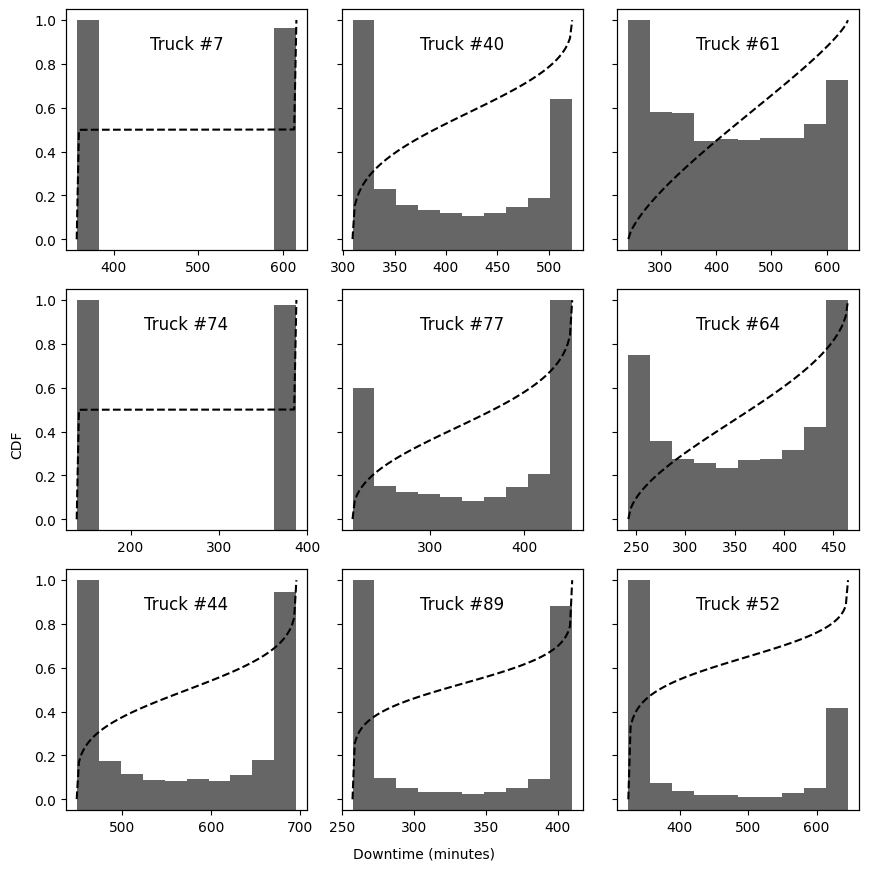

In [83]:
import datetime as dt
from math import sqrt
import zoneinfo
import pandas as pd
import numpy as np
from scipy.stats import beta, triang
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)


def time_to_float(timestamp: dt.datetime | str, tz=None, fmt='%H:%M:%S') -> float:
    if isinstance(timestamp, float):
        return timestamp

    if isinstance(timestamp, str):
        timestamp = dt.datetime.strptime(timestamp, fmt)

    if tz:
        if isinstance(tz, str):
            tz = zoneinfo.ZoneInfo(tz)
        timestamp = timestamp.astimezone(tz)

    return timestamp.hour + timestamp.minute / 60.0 + timestamp.second / 3600.0


class FailSim:
    LOADING_TIME_PARAMS = (3, 4.5, 6)
    UNLOADING_TIME_PARAMS = (1.2, 2.7, 3.9)
    TRAVEL_TIME_PARAMS = (15.5, 16.7, 18)

    def __init__(self, excel_filename: str):
        self.df = self.load_from_excel(excel_filename)

    def load_from_excel(self, filename: str):
        df = pd.read_excel(filename)
        df['date'] = df['date'].ffill()
        df['day'] = df['date'].str.split('/').str[0]
        df['total_work_time'] = df['total_work_time'].apply(time_to_float)
        df['failure_time'] = df['failure_time'].apply(time_to_float)
        return df

    def pert_cdf(self, low: float, mode: float, high: float, **kwargs):
        loc, scale = low, high - low
        c = (mode - low) / scale
        x = np.linspace(triang.ppf(0.001, c, loc, scale), triang.ppf(0.999, c, loc, scale), 100)
        y = triang.cdf(x, c, loc, scale)
        return x, y

    def pert_pdf(self, low: float, mode: float, high: float, **kwargs):
        loc, scale = low, high - low
        c = (mode - low) / scale
        x = np.linspace(triang.ppf(0.001, c, loc, scale), triang.ppf(0.999, c, loc, scale), 100)
        y = triang.pdf(x, c, loc, scale)
        return x, y

    def beta_pdf(self, a: float, b: float, loc: float, scale: float, **kwargs):
        x = np.linspace(beta.ppf(0.001, a, b, loc, scale), beta.ppf(0.999, a, b, loc, scale), 100)
        y = beta.pdf(x, a, b, loc, scale)
        return x, y

    def beta_cdf(self, a: float, b: float, loc: float, scale: float, **kwargs):
        x = np.linspace(beta.ppf(0.001, a, b, loc, scale), beta.ppf(0.999, a, b, loc, scale), 100)
        y = beta.cdf(x, a, b, loc, scale)
        return x, y

    def truck_list(self):
        return self.df['truck_id'].unique()

    def truck_work_dist(self, truck_id: int):
        return self.df[self.df['truck_id'] == truck_id]['total_work_time'].dropna() * 60

    def truck_failure_dist(self, truck_id: int):
        return self.df[self.df['truck_id'] == truck_id]['failure_time'].dropna() * 60

    def truck_failure_prob(self, truck_id: int):
        failed_count = len(self.df[self.df['truck_id'] == truck_id]['failure_time'].dropna())
        total_count = len(self.df[self.df['truck_id'] == truck_id])
        return failed_count / total_count if total_count > 0 else 0

    def truck_work_beta(self, truck_id: int):
        return self._beta_fit(self.truck_work_dist(truck_id).values)

    def truck_failure_beta(self, truck_id: int):
        if not (data := self.truck_failure_dist(truck_id)).empty:
            return self._beta_fit(data.values)

    def cycle_time_sim_data(self, truck_id: int, size: int):
        result = self._loading_time_rvs(size) + self._travel_time_rvs(size) * 2 + self._unloading_time_rvs(size)
        if (failure_data := self._truck_failure_time_rvs(truck_id, size)) is not None:
            result += self._truck_failed_rvs(truck_id, size) * failure_data

        return result

    def cycle_time_sim_stat(self, truck_id: int):
        data = self.cycle_time_sim_data(truck_id, 1000)
        a, b, loc, scale = beta.fit(data, floc=data.min(), fscale=data.max() - data.min(), method='MM')
        mean = a / (a + b) * scale + loc
        stdev = scale * sqrt(a * b) / (a + b) / sqrt(a + b + 1)
        return mean, stdev

    def cycle_time_pert_stat(self, truck_id: int):
        failure_pert = self._truck_failure_time_pert(truck_id)
        mean = (
            self._pert_mean(*self.LOADING_TIME_PARAMS)
            + self._pert_mean(*self.TRAVEL_TIME_PARAMS) * 2
            + self._pert_mean(*self.UNLOADING_TIME_PARAMS)
            + self.truck_failure_prob(truck_id) * self._pert_mean(*failure_pert)
        )
        stdev = sqrt(
            sum(
                map(
                    lambda x: x**2,
                    (
                        self._pert_stdev(*self.LOADING_TIME_PARAMS),
                        self._pert_stdev(*self.TRAVEL_TIME_PARAMS) * 2,
                        self._pert_stdev(*self.UNLOADING_TIME_PARAMS),
                        self._pert_stdev(*failure_pert),
                    ),
                )
            )
        )
        return mean, stdev

    def _beta_fit(self, data):
        floc, fscale = data.min(), data.max() - data.min()  # pyright: ignore[reportAttributeAccessIssue]
        return beta.fit(data, floc=floc, fscale=fscale, method='MM')

    def _beta_to_pert(self, a: float, b: float, loc: float, scale: float):
        mode = loc + scale * (a - 1) / (a + b - 2)
        return loc, mode, loc + scale

    def _pert_to_beta(self, low: float, mode: float, high: float):
        scale = high - low
        k = (mode - low) / scale if scale != 0 else 0.5
        a = 1 + 4 * k
        b = 1 + 4 * (1 - k)
        return a, b, low, scale

    def _pert_mean(self, low: float, mode: float, high: float):
        return (low + 4 * mode + high) / 6

    def _pert_stdev(self, low: float, mode: float, high: float):
        return (high - low) / 6

    def _random_beta(self, a: float, b: float, loc: float, scale: float, size: int):
        return beta.rvs(a, b, loc, scale, size=size)

    def _random_pert(self, low: float, mode: float, high: float, size: int):
        return beta.rvs(*self._pert_to_beta(low, mode, high), size=size)

    def _random_triang(self, low: float, mode: float, high: float, size: int):
        c = (mode - low) / (high - low)
        return triang.rvs(c=c, loc=low, scale=high - low, size=size)

    def _truck_failure_time_pert(self, truck_id: int):
        data = self._truck_failed_rvs(truck_id, 1000) * self._truck_failure_time_rvs(truck_id, 1000)
        return self._beta_to_pert(*beta.fit(data, floc=data.min(), fscale=data.max() - data.min(), method='MM'))

    def _loading_time_rvs(self, size: int):
        return self._random_pert(*self.LOADING_TIME_PARAMS, size)

    def _unloading_time_rvs(self, size: int):
        return self._random_pert(*self.UNLOADING_TIME_PARAMS, size)

    def _travel_time_rvs(self, size: int):
        return self._random_pert(*self.TRAVEL_TIME_PARAMS, size)

    def _truck_failed_rvs(self, truck_id: int, size: int):
        return (np.random.random(size) <= self.truck_failure_prob(truck_id)).astype(int)

    def _truck_failure_time_rvs(self, truck_id, size: int):
        if params := self.truck_failure_beta(truck_id):
            return self._random_beta(*params, size=size)

    def plot_all_trucks_failure_beta(self, cols: int):
        truck_beta_params = {
            truck_id: params
            for truck_id in self.truck_list()
            if (params := self.truck_failure_beta(truck_id)) is not None
        }
        rows = (len(truck_beta_params) + 2) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3), sharey=True)
        ax: plt.Axes
        for ax, (truck_id, params) in zip(axes.flat, truck_beta_params.items()):
            x, y = self.beta_cdf(*params)
            ax2 = ax.twinx()
            if (data := self._truck_failure_time_rvs(truck_id, 10000)) is not None:
                ax2.hist(data, color='k', alpha=0.6, density=True)
                ax2.yaxis.set_visible(False)
            ax.set_title(f'Truck #{truck_id}', loc='center', y=0.8)
            ax.plot(x, y, 'k--')
        fig.text(0.5, 0.04, 'Downtime (minutes)', ha='center')
        fig.text(0.04, 0.5, 'CDF', va='center', rotation='vertical')
        fig.tight_layout(rect=(0.05, 0.05, 1, 1))
        plt.show()


sim = FailSim('data.xlsx')
# print('pert:', sim.cycle_time_pert_stat(61))
# print('sim:', sim.cycle_time_sim_stat(61))
sim.plot_all_trucks_failure_beta(3)